**Homework 07 **

**Jena Climate datasets**

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os

In [38]:
tf.__version__

'2.3.0'

In [39]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/jena_climate_2009_2016.csv')
df.shape[0]


420551

**Raw Data Visualization**

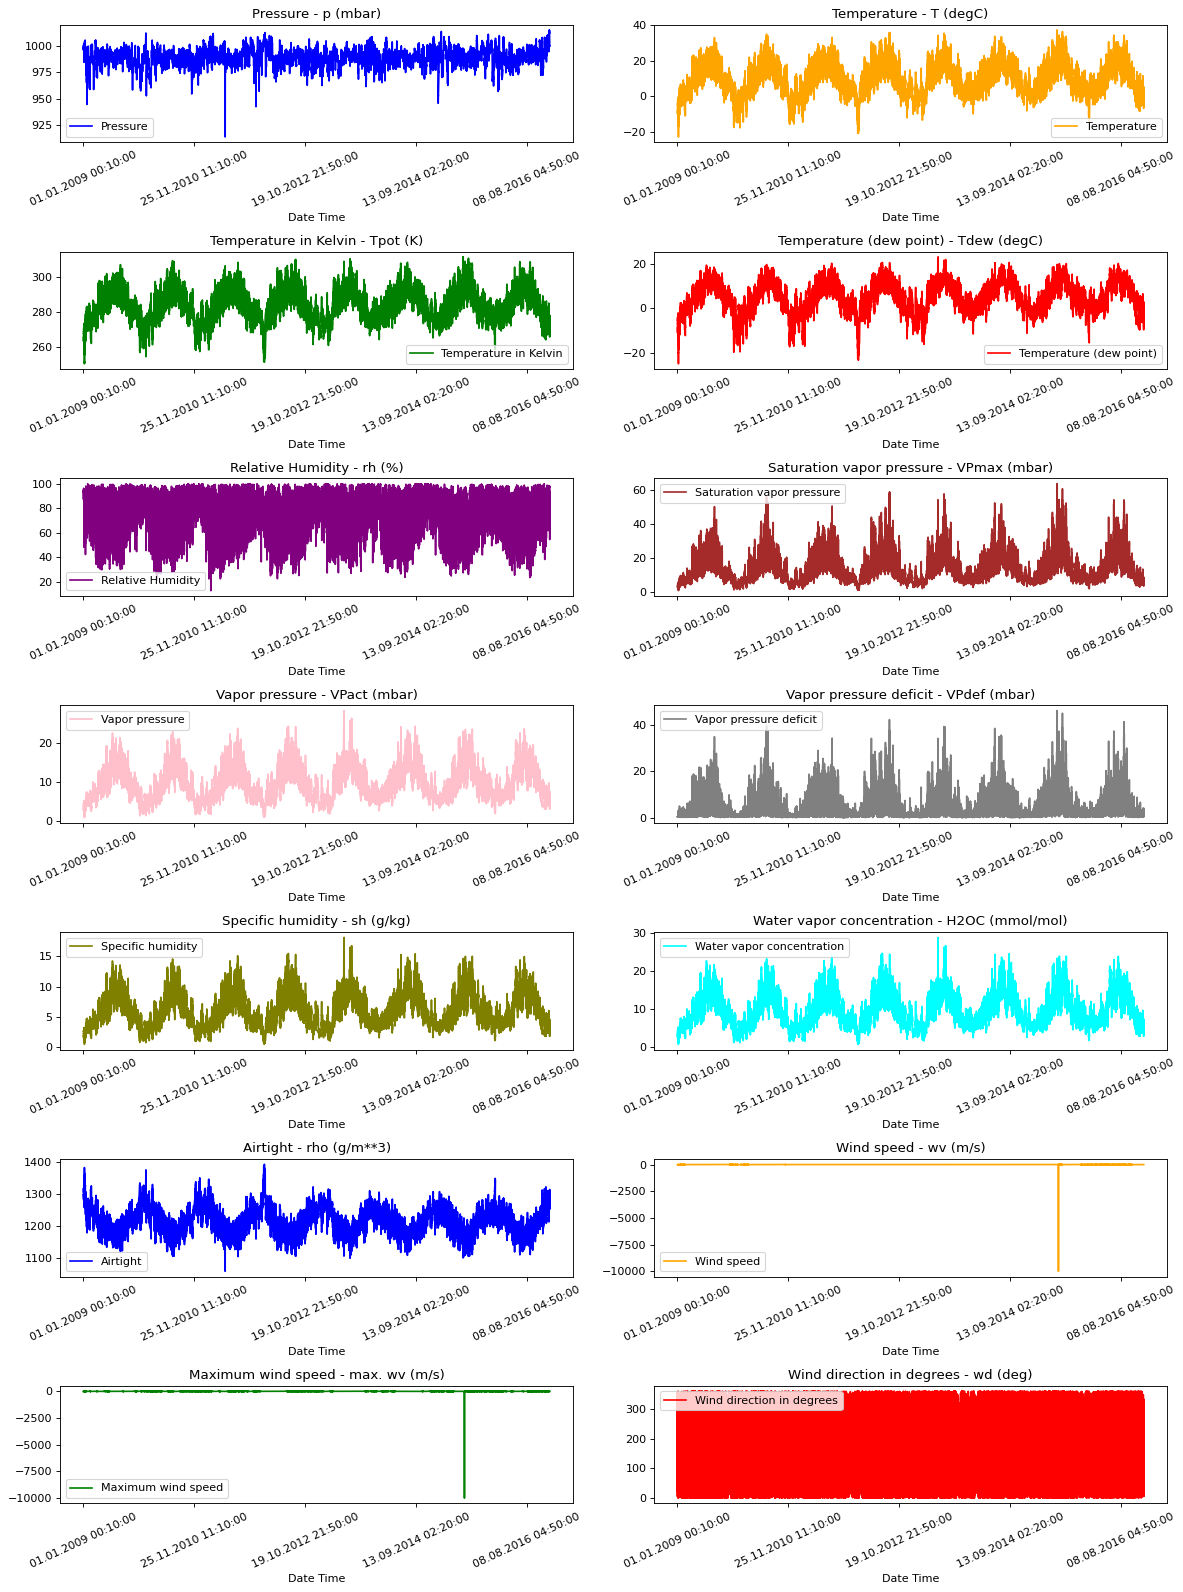

In [40]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

***Heat map which shows the correlation between different features***

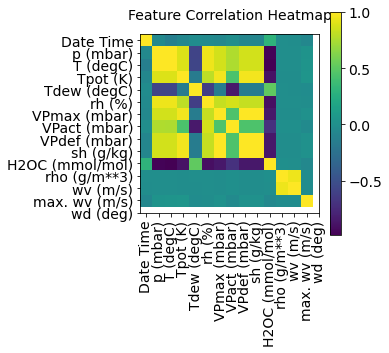

In [41]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)


**Data Preprocessing**


```
# we normalize to confine feature values to a range of [0,1] before training a neural network by substracting the mean and dividing by the standard deviation of each feature
```



In [42]:
split_fraction = 0.715 #71.5% of data will be used training model 
train_split = int(split_fraction * int(df.shape[0])) #300,693 rows
print(train_split)
step = 6

past = 720
future = 72 # the temperature after 72(12 hours*6 observation per hour) observation will be used as a label
learning_rate = 0.001
batch_size = 256
epochs = 10


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

300693


In [43]:
# Using selected features
print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = df[selected_features]
features.index = df[date_time_key]
features.head()

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

The selected parameters are: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


In [14]:
train_data

,0,1,2,3,4,5,6
0,0.955451,-2.000020,-1.319782,-0.788479,-1.500927,2.237658,-0.732997
1,0.961528,-2.045185,-1.332806,-0.790561,-1.519521,2.287838,-0.936002
2,0.956666,-2.056766,-1.335410,-0.792642,-1.523239,2.298608,-1.283076
3,0.954236,-2.033604,-1.328898,-0.794724,-1.508364,2.272906,-1.184847
4,0.954236,-2.028972,-1.327596,-0.794724,-1.508364,2.268256,-1.197944
...,...,...,...,...,...,...,...
300688,-0.104339,0.853478,0.713250,-0.116113,1.429472,-0.878353,-0.890162
300689,-0.101908,0.881272,0.752322,-0.024521,1.392285,-0.900138,-0.477604
300690,-0.111631,0.902117,0.780974,0.021274,1.392285,-0.920454,-0.791934
300691,-0.117708,0.896327,0.771857,0.012948,1.388566,-0.916538,-0.791934


In [15]:
val_data

,0,1,2,3,4,5,6
300693,-0.109200,0.855794,0.717157,-0.072399,1.384847,-0.879577,-0.942551
300694,-0.110416,0.852320,0.711948,-0.078644,1.381128,-0.876639,-1.302721
300695,-0.107985,0.788626,0.627292,-0.205623,1.373691,-0.820830,-1.197944
300696,-0.109200,0.734196,0.556963,-0.305541,1.358816,-0.773343,-1.217590
300697,-0.109200,0.679767,0.487936,-0.386725,1.325347,-0.724388,-0.667512
...,...,...,...,...,...,...,...
420546,1.386902,-1.540264,-1.164797,-0.580316,-1.456301,1.876123,-0.968745
420547,1.369887,-1.459199,-1.132237,-0.534520,-1.452583,1.789472,-0.660963
420548,1.356518,-1.437195,-1.123121,-0.511622,-1.460020,1.763770,-0.700254
420549,1.355303,-1.561109,-1.172611,-0.571990,-1.482333,1.890320,-0.431764


**Training dataset**

In [44]:
start = past + future #720+72
end = start + train_split #301785

x_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[1]]

sequence_length = int(past / step)

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [12]:
end

301485

In [14]:
len(val_data)

119858

# **VALIDATION DATASET **

The validation dataset must not contain the last 792 rows as we won't have label data for those records, hence 792 must be substracted from the end of the data

In [46]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 120, 7)
Target shape: (256, 1)


**GRAPH VISUALIZATION FOR LOSS FUNCTION**

In [47]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

*Expt 1 Using simple  model *

**Results are not so good**

In [38]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

inputs = keras.layers.Input(shape =(inputs.shape[-1]))
model = Sequential()

#model.add(layers.Flatten(input_shape=(240,14)))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(1))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")


path_checkpoint = "model_checkpoint1.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1171/1172 [============================>.] - ETA: 0s - loss: 0.5617
Epoch 00001: val_loss improved from inf to 84.41956, saving model to model_checkpoint1.h5
1172/1172 [==============================] - 61s 52ms/step - loss: 0.5616 - val_loss: 84.4196
Epoch 2/10
1171/1172 [============================>.] - ETA: 0s - loss: 0.3842
Epoch 00002: val_loss did not improve from 84.41956
1172/1172 [==============================] - 61s 52ms/step - loss: 0.3841 - val_loss: 134.4845
Epoch 3/10
1171/117

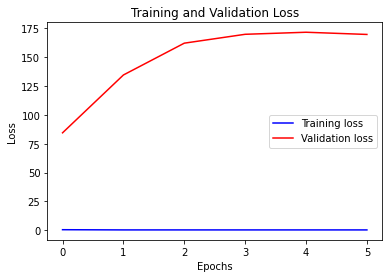

In [40]:
visualize_loss(history, "Training and Validation Loss")

**Expt-2: Using lstm layer of 32 units**

In [21]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 7)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                5120      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


In [14]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
512/512 [==============================] - ETA: 0s - loss: 0.2017
Epoch 00001: val_loss improved from inf to 0.28275, saving model to model_checkpoint.h5
512/512 [==============================] - 73s 144ms/step - loss: 0.2017 - val_loss: 0.2828
Epoch 2/10
512/512 [==============================] - ETA: 0s - loss: 0.1437
Epoch 00002: val_loss improved from 0.28275 to 0.17239, saving model to model_checkpoint.h5
512/512 [==============================] - 72s 141ms/step - loss: 0.1437 - val_loss: 0.1724
Epoch 3/10
512/512 [==============================] - ETA: 0s - loss: 0.1188
Epoch 00003: val_loss improved from 0.17239 to 0.15744, saving model to model_checkpoint.h5
512/512 [==============================] - 72s 141ms/step - loss: 0.1188 - val_loss: 0.1574
Epoch 4/10
512/512 [==============================] - ETA: 0s - loss: 0.1141
Epoch 00004: val_loss improved from 0.15744 to 0.15318, saving model to model_checkpoint.h5
512/512 [==============================] - 72s 141ms

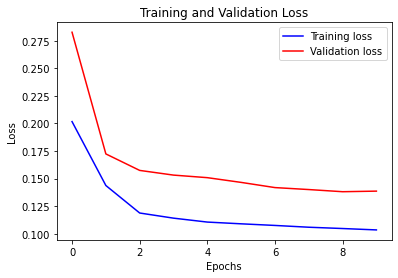

In [16]:
visualize_loss(history, "Training and Validation Loss")

***Prediction***

**The trained model above is now able to make predictions for 5 sets of values from validation set.**

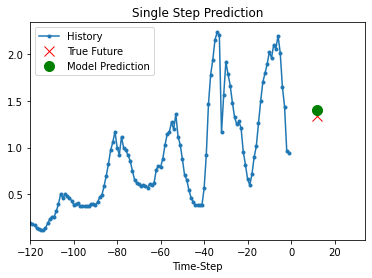

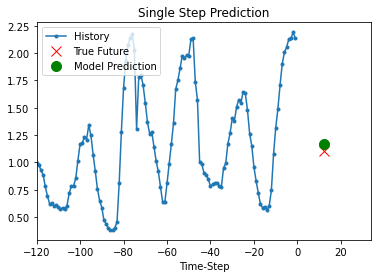

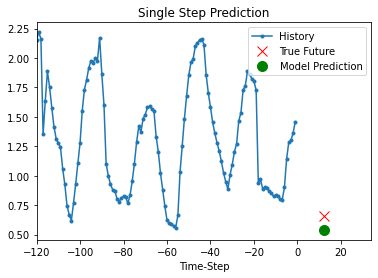

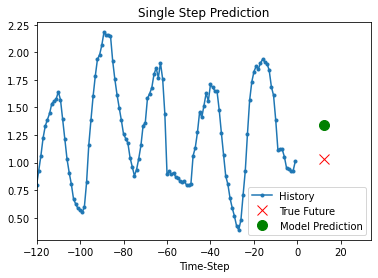

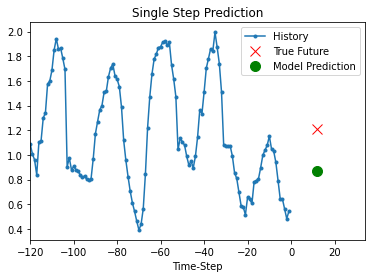

In [45]:

def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )

**Expt -3: Using GRU layer of 32 Units**

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 120, 7)]          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                3936      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 33        
Total params: 3,969
Trainable params: 3,969
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1172/1172 [==============================] - ETA: 0s - loss: 0.2031
Epoch 00001: val_loss improved from inf to 0.19809, saving model to model_checkpoint.h5
1172/1172 [==============================] - 156s 133ms/step - loss: 0.2031 - val_loss: 0.1981
Epoch 2/10
1172/1172 [==============================] - ETA: 0s - loss: 0.1354
Epoch 00002: val_loss improved from 0.198

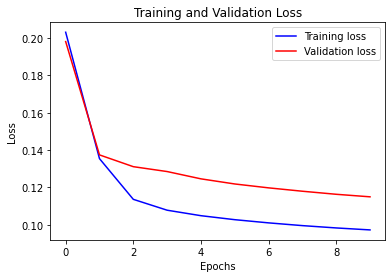

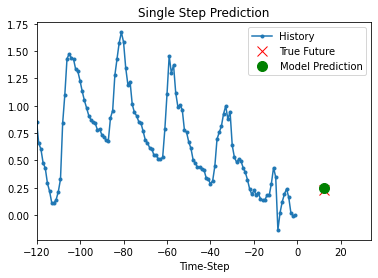

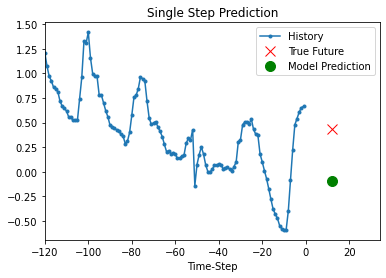

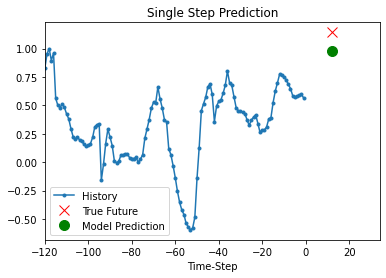

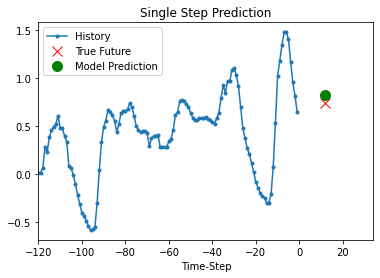

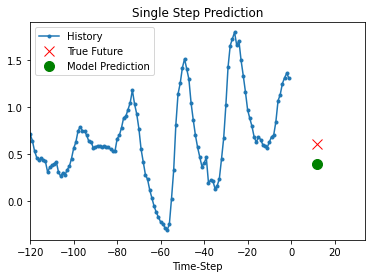

In [49]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.GRU(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)
#loss visualization
visualize_loss(history, "Training and Validation Loss")

# Prediction
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )


**Expt -4: Using Recurrent Dropout of 0.2**
### Loss of model is decreasing than the previous one 
### And the prediction is also more accurate

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 120, 7)]          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                3936      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 33        
Total params: 3,969
Trainable params: 3,969
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1172/1172 [==============================] - ETA: 0s - loss: 0.2736
Epoch 00001: val_loss improved from inf to 0.16969, saving model to model_checkpoint.h5
1172/1172 [==============================] - 235s 200ms/step - loss: 0.2736 - val_loss: 0.1697
Epoch 2/10
1172/1172 [==============================] - ETA: 0s - loss: 0.1542
Epoch 00002: val_loss improved from 0.169

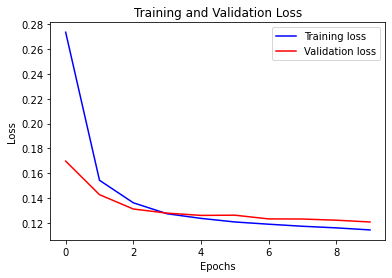

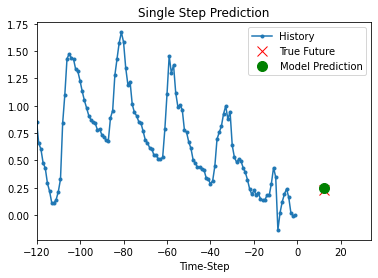

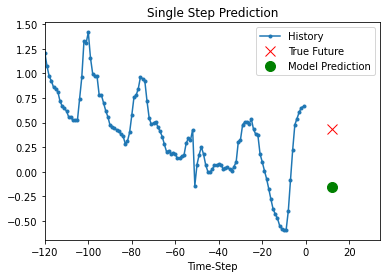

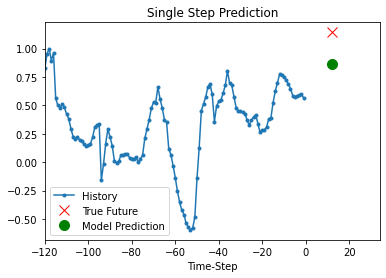

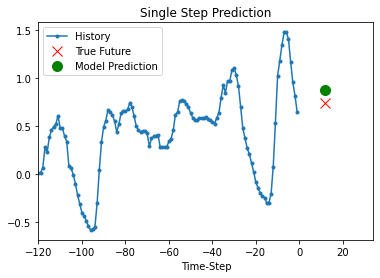

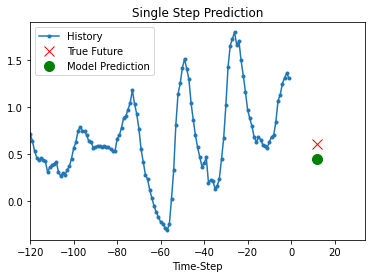

In [50]:
lstm_out = keras.layers.GRU(32,dropout = 0.2, recurrent_dropout = 0.2)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

path_checkpoint = "/content/drive/My Drive/Colab Notebooks/model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)
#loss visualization
visualize_loss(history, "Training and Validation Loss")

# Prediction
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )


In [52]:
model.save_weights("/content/drive/My Drive/Colab Notebooks/model_checkpoint.h5")

**EXPT-4 Model is still improving so we can train for more epochs**

***Lets train for 30 epochs with low learning rate***

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 120, 7)]          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                3936      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 3,969
Trainable params: 3,969
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1172/1172 [==============================] - ETA: 0s - loss: 0.5991
Epoch 00001: val_loss improved from inf to 0.22565, saving model to /content/drive/My Drive/Colab Notebooks/model_checkpoint2.h5
1172/1172 [==============================] - 219s 187ms/step - loss: 0.5991 - val_loss: 0.2257
Epoch 2/30
1172/1172 [==============================] - ETA: 0s - loss: 0.2578


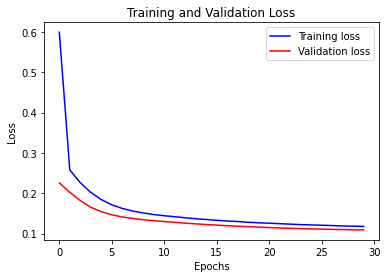

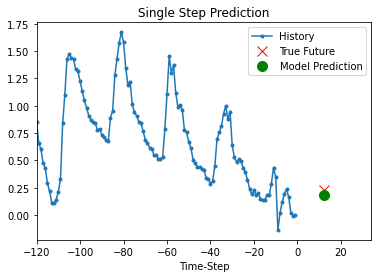

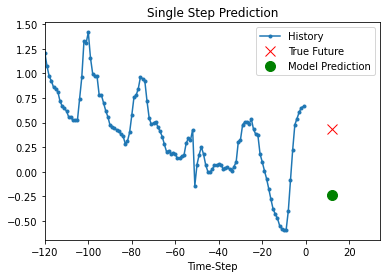

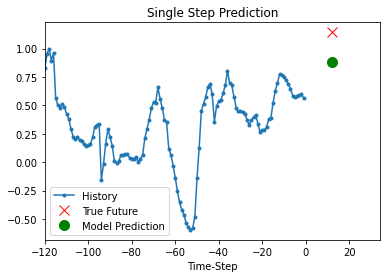

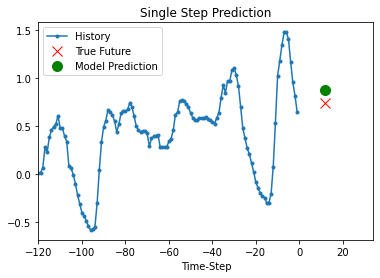

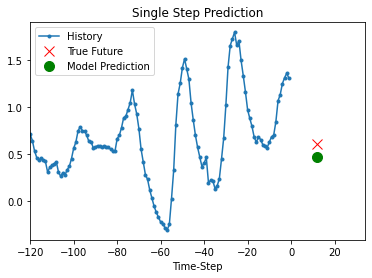

In [23]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.GRU(32,dropout = 0.2, recurrent_dropout = 0.2)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss="mse")
model.summary()

path_checkpoint = "/content/drive/My Drive/Colab Notebooks/model_checkpoint2.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=30,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)
#loss visualization
visualize_loss(history, "Training and Validation Loss")

# Prediction
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )

**EXPT -5: Increasing one more GRU layer with 64 units [32-64] Stacking Recurrent Layer and changing loss function to 'mae'**

Model: "functional_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 120, 7)]          0         
_________________________________________________________________
gru_21 (GRU)                 (None, 120, 32)           3936      
_________________________________________________________________
gru_22 (GRU)                 (None, 64)                18816     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 22,817
Trainable params: 22,817
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1172/1172 [==============================] - ETA: 0s - loss: 0.4077
Epoch 00001: val_loss improved from inf to 0.32640, saving model to /content/drive/My Drive/Colab Notebooks/model_checkpoint3.h5
1172/1172 [============================

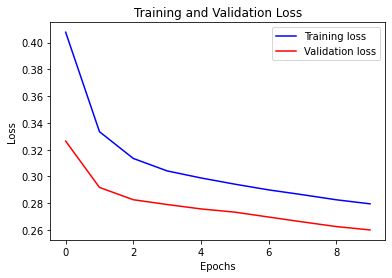

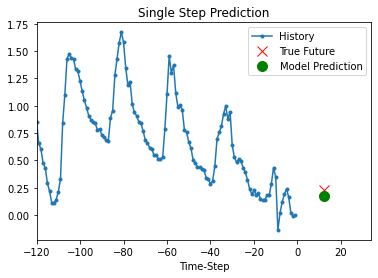

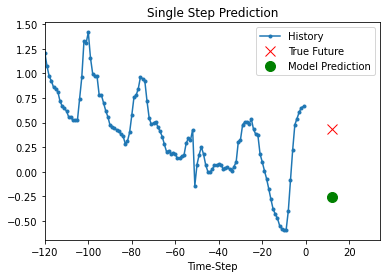

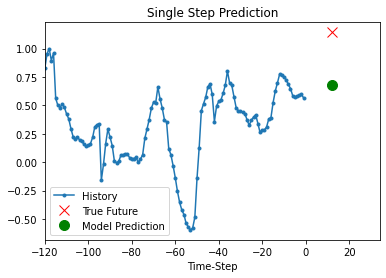

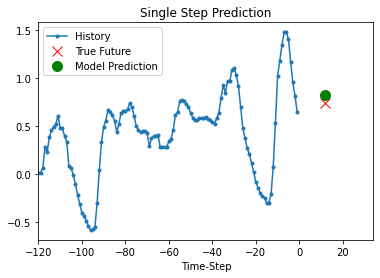

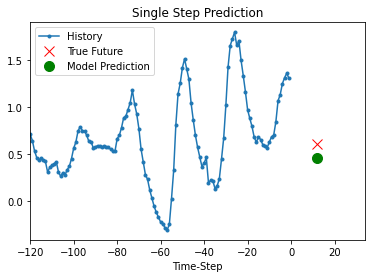

In [48]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.GRU(32,dropout = 0.1, recurrent_dropout = 0.5,return_sequences=True)(inputs)
lstm_out1 = keras.layers.GRU(64,dropout = 0.1, recurrent_dropout = 0.5)(lstm_out)
outputs = keras.layers.Dense(1)(lstm_out1)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss="mae")
model.summary()

path_checkpoint = "/content/drive/My Drive/Colab Notebooks/model_checkpoint3.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=10,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)
#loss visualization
visualize_loss(history, "Training and Validation Loss")

# Prediction
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )